# GEE Delivery with the Subscriptions API

In this notebook we're going to cover how to order data using the [Subscriptions API](https://developers.planet.com/docs/subscriptions/) and deliver it to [Google Earth Engine (GEE)](https://earthengine.google.com/) using [Planet’s GEE Delivery Integration](https://developers.planet.com/docs/integrations/gee/).

**Prerequisites:** 
- [Planet's Python SDK 2.0](https://github.com/planetlabs/planet-client-python) installed and initialized in your environment. Please follow instructions in [our docs](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/quick-start-guide/) to authenticate your account with Planet servers. (**This notebook is not compatible with earlier versions of Planet's Python SDK**)
- The Earth Engine python api installed in your environment. Please follow instructions in [our docs](https://developers.google.com/earth-engine/python_install) to install the Earth Engine python api.
- A GEE project with EE API enabled - `planet-earthengine-staging`
- A pre-existing GEE [ImageCollection](https://developers.google.com/earth-engine/guides/ic_creating) - `gee-integration-testing`
- Sufficient Quota
- A service account key file with EE editor access to the GEE project

### Setting up credentials

In [2]:
import planet
import ee
import os
import base64
from planet import Auth, Session, SubscriptionsClient

API_KEY = os.environ.get("PLANET_API_KEY")
JSON_KEY_FILE_PATH = "<SERVICE_ACCOUNT_JSON_FILE_PATH>"

with open(JSON_KEY_FILE_PATH, "rb") as f:
    base64_key = base64.b64encode(f.read()).decode()

auth = Auth.from_key(API_KEY)

### Set up source block

In [5]:
import datetime

aoi = {
    "coordinates": [
        [
            [139.5648193359375, 35.42374884923695],
            [140.1031494140625, 35.42374884923695],
            [140.1031494140625, 35.77102915686019],
            [139.5648193359375, 35.77102915686019],
            [139.5648193359375, 35.42374884923695],
        ]
    ],
    "type": "Polygon",
}

start_time = datetime.datetime.now() - datetime.timedelta(days=10)
start_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0)
end_time = start_time + datetime.timedelta(days=30)

source = planet.subscription_request.catalog_source(
    item_types=["PSScene"],
    asset_types=["ortho_analytic_4b", "ortho_udm2", "ortho_visual"],
    geometry=aoi,
    start_time=start_time,
    end_time=end_time,
)

### Set up delivery block and create subscription

In [8]:
earth_engine_delivery = {
    "type": "google_earth_engine",
    "parameters": {
        "project": "planet-earthengine-staging",
        "collection": "gee-integration-testing",
        "credentials": base64_key,
    },
}


sub_desc = planet.subscription_request.build_request(
    name="gee-integration-test",
    source=source,
    delivery=earth_engine_delivery,
)

# Now we can create a corresponding subscription using our description
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    sub = await cl.create_subscription(sub_desc)

sub

{'name': 'gee-integration-test',
 'source': {'type': 'catalog',
  'parameters': {'asset_types': ['ortho_analytic_4b',
    'ortho_udm2',
    'ortho_visual'],
   'item_types': ['PSScene'],
   'geometry': {'coordinates': [[[139.5648193359375, 35.42374884923695],
      [140.1031494140625, 35.42374884923695],
      [140.1031494140625, 35.77102915686019],
      [139.5648193359375, 35.77102915686019],
      [139.5648193359375, 35.42374884923695]]],
    'type': 'Polygon'},
   'start_time': '2023-09-08T00:00:00Z',
   'end_time': '2023-10-08T00:00:00Z',
   'publishing_stages': ['standard', 'finalized'],
   'time_range_type': 'published'}},
 'delivery': {'type': 'google_earth_engine',
  'parameters': {'collection': 'gee-integration-testing',
   'credentials': '<REDACTED>',
   'project': 'planet-earthengine-staging'}},
 'created': '2023-09-18T18:57:08.319871Z',
 '_links': {'_self': 'https://api.planet.com/subscriptions/v1/b3272acc-c198-44e0-8c77-35b2d17838e4'},
 'status': 'preparing',
 'id': 'b327

### Wait for subscription to run, and wait for results

In [13]:
import time

async with Session(auth=auth) as sess:
    ## first wait for subscription to transition to ready/completed
    until = datetime.datetime.now() + datetime.timedelta(minutes=5)
    while datetime.datetime.now() < until:
        cl = SubscriptionsClient(sess)
        sub = await cl.get_subscription(subscription_id=sub["id"])
        if sub["status"] in ["preparing", "pending"]:
            print(f'Current status: {sub["status"]}. Sleeping for 10 seconds')
            time.sleep(10)
        elif sub["status"] == "running":
            print(f'Subscription: {sub["id"]} is now running')
            break
        elif sub["status"] == "completed":
            print(f'Subscription: {sub["id"]} is completed')
            break
        else:
            raise RuntimeError(
                f'Subscription: {sub["id"]} resulted in status: {sub["status"]}'
            )
    if sub["status"] != "completed" and sub["status"] != "running":
        raise RuntimeError(
            f'Subscription: {sub["id"]} did not transition to running in time'
        )

    # thnn wait for some results to appear
    until = datetime.datetime.now() + datetime.timedelta(minutes=5)
    results = []
    while datetime.datetime.now() < until:
        results_desc = cl.get_results(subscription_id=sub["id"], limit=5)
        results_desc_list = [i async for i in results_desc]
        if len(results_desc_list) == 0:
            print(f"No results yet. Sleeping for 10 seconds")
            time.sleep(10)
        else:
            for result in results_desc_list:
                if result["status"] == "queued":
                    print(f'Result: {result["id"]} is queued')
                elif result["status"] == "running":
                    print(f'Result: {result["id"]} is still running')
                elif result["status"] == "processing":
                    print(f'Result: {result["id"]} is still running')
                elif result["status"] == "failed":
                    print(f'Result: {result["id"]} failed')
                elif result["status"] == "success":
                    print(f'Result: {result["id"]} succeeded')
                    results.append(result)
                else:
                    raise RuntimeError(
                        f'Result: {result["id"]} resulted in status: {result["status"]}'
                    )
            if len(results) > 0:
                break
            print("results not ready")
            break
    if not results:
        raise RuntimeError(
            f'Subscription: {sub["id"]} did not return any results in time'
        )

results

Subscription: b3272acc-c198-44e0-8c77-35b2d17838e4 is now running
Result: ccdec65c-73a7-48be-9562-dab559e1aade is still running
Result: c26ac3c6-e5bf-4625-b0ea-a0774d48a842 succeeded
Result: 92e85d56-b2e2-496a-9e6d-02aa26d2cca8 is still running
Result: f924409a-34cf-4637-b39f-fb22618a3082 is still running
Result: 8ba9aca0-d1b8-476c-91aa-e781f0cec4da succeeded


[{'id': 'c26ac3c6-e5bf-4625-b0ea-a0774d48a842',
  'status': 'success',
  'properties': {'item_id': '20230912_003259_12_24b4',
   'item_types': ['PSScene']},
  'created': '2023-09-18T18:57:13.615322Z',
  'updated': '2023-09-18T19:05:27.207838Z',
  'completed': '2023-09-18T19:05:27.207838Z',
  'errors': {},
  'outputs': ['3IY7YWR4YXJT3ABZQKEQLZUP (projects/planet-earthengine-staging/assets/gee-integration-testing/20230912_003259_12_24b4_3B_AnalyticMS)',
   'DPU6EY4URKABCKPOZEDBJEBB (projects/planet-earthengine-staging/assets/gee-integration-testing/20230912_003259_12_24b4_3B_Visual)']},
 {'id': '8ba9aca0-d1b8-476c-91aa-e781f0cec4da',
  'status': 'success',
  'properties': {'item_id': '20230910_003337_52_2442',
   'item_types': ['PSScene']},
  'created': '2023-09-18T18:57:13.615289Z',
  'updated': '2023-09-18T19:05:47.238997Z',
  'completed': '2023-09-18T19:05:47.238997Z',
  'errors': {},
  'outputs': ['YPOTBYMWG5CHMPZSOPQODBA5 (projects/planet-earthengine-staging/assets/gee-integration-t

### Wait for images to ingest into GEE

Above we can see some successful subscription deliveries to GEE. Here "success" just means our delivery system has kicked off an image [import task](https://developers.google.com/earth-engine/reference/rest/v1/projects.image/import). Since this import task was initiated using the service account we provided in the delivery configuration, we can check the status of our import task by authenticating with the python EE client using the same service account credentials.  

In the results json above, the GEE task ID is stored in the results list, along with the EE asset path, seperated by a space.


In [15]:
ee_creds = ee.ServiceAccountCredentials(None, key_file=JSON_KEY_FILE_PATH)
ee.Initialize()

output = results[0]["outputs"][0]
split_output = output.split(" ")
task_id = split_output[0]
asset_path = split_output[1][1:-1]  # remove parentheses

until = datetime.datetime.now() + datetime.timedelta(minutes=5)
while datetime.datetime.now() < until:
    task = ee.data.getTaskStatus(task_id)[0]
    if task["state"] == "READY":
        print(f"Task: {task_id} is ready")
        ee.data.startProcessing(task_id)
    if task["state"] == "RUNNING":
        print(f"Task: {task_id} is still running")
        time.sleep(10)
    elif task["state"] == "COMPLETED":
        print(f"Task: {task_id} completed")
        break
    elif task["state"] == "FAILED" or task["state"] == "CANCELLED":
        print(f"Task: {task_id} failed or cancelled: {task}")
        break
    else:
        raise RuntimeError(
            f'Task: {task_id} resulted in status: {task["state"]}: {task}'
        )
if task["state"] != "COMPLETED":
    raise RuntimeError(f"Task: {task_id} did not complete in time")
task

Task: 3IY7YWR4YXJT3ABZQKEQLZUP completed


{'state': 'COMPLETED',
 'description': 'Ingest image: "projects/planet-earthengine-staging/assets/gee-integration-testing/20230912_003259_12_24b4_3B_AnalyticMS"',
 'creation_timestamp_ms': 1695063915509,
 'update_timestamp_ms': 1695065068731,
 'start_timestamp_ms': 1695064447988,
 'task_type': 'INGEST_IMAGE',
 'destination_uris': ['https://code.earthengine.google.com/?asset=projects/planet-earthengine-staging/assets/gee-integration-testing/20230912_003259_12_24b4_3B_AnalyticMS'],
 'attempt': 1,
 'id': '3IY7YWR4YXJT3ABZQKEQLZUP',
 'name': 'projects/earthengine-legacy/operations/3IY7YWR4YXJT3ABZQKEQLZUP'}

### Get Earth engine image properties

Below, we can see some of the info of the image we ingested into Earth Engine. It includes metadata you would typically find in metadata.json/data api, in addition to `subscription_id`. Since we included the `orth_udm2` asset type in the `asset_types` field of the subscription source block, the udm bands are appended to the BGRN bands you would typically find in `ortho_analytic_4b`.  

In [19]:
info = ee.Image(asset_path).getInfo()
info

{'type': 'Image',
 'bands': [{'id': 'Blue',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [12834, 9273],
   'crs': 'EPSG:32654',
   'crs_transform': [3, 0, 370287, 0, -3, 3956373]},
  {'id': 'Green',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [12834, 9273],
   'crs': 'EPSG:32654',
   'crs_transform': [3, 0, 370287, 0, -3, 3956373]},
  {'id': 'Red',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [12834, 9273],
   'crs': 'EPSG:32654',
   'crs_transform': [3, 0, 370287, 0, -3, 3956373]},
  {'id': 'Near-Infrared',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [12834, 9273],
   'crs': 'EPSG:32654',
   'crs_transform': [3, 0, 370287, 0, -3, 3956373]},
  {'id': 'udm2_1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',

### Visualize the image in Earth Engine

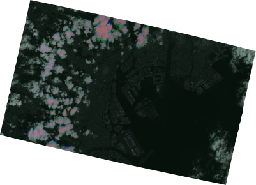

In [22]:
params = {
    'dimensions': 256,
    'bands': ['Red', 'Green', 'Blue'],
}
url = ee.Image(asset_path).getThumbURL(params)

import requests
from IPython.display import Image

Image(requests.get(url).content)